In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Example problem

There are $i=1,...,n$ regions. Together the regions have $L$ agents: in each one, there are $L_i$ agents, and $\sum L_i=1$.

Each region produces a good and buys goods from all other regions. The local production technology is linear in labor.

$$
y_i = A_i l_i
$$

In equilibrium, we need $l_i = L_i$. Workers are paid a wage $w_i$ (which we also need to solve for).

This gives us our basic system. First, there is a labor market clearing condition, which postulates that the income earned in $i$ must be equal to the total money every region pays for $i$'s good:

$$
w_iL_i = \sum_j \pi_{ji} w_j L_j
$$

Second, there is a spatial equilibrium condition, which states that workers are indifferent across regions:
$$
L_i = \frac{
exp \Big(\frac{w_i}{ (\sum_k (\frac{w_k}{A_k})^{1-\sigma})^{\frac{1}{1-\sigma}}  }  \Big)^\eta
}{
\sum_j exp \Big(\frac{w_j}{ (\sum_k (\frac{w_k}{A_k})^{1-\sigma})^{\frac{1}{1-\sigma}}  }  \Big)^\eta
}
$$

## Solving for wages

In [6]:
def normalize(Lf):
    Lf /= np.sum(Lf, axis=0)
    return Lf

def difference(v1, v2):
        return sum((v1-v2)**2)

a = np.random.randn(10)
sum(normalize(a))

0.9999999999999998

The `Tracer` class will be useful for tracking values

In [166]:
class Tracer:
    def __init__(self, print_every=0):
        self.history = []
        self.last = None
        self.print_every = print_every
        self.iterations = 0
        
    @property
    def length(self):
        return len(self.history)
    
    def log(self, value):
        self.iterations += 1
        self.last = value
        self.history.append(value)
        if self.print_every > 0 and self.iterations % self.print_every == 0:
            print('Iteration #{}:'.format(self.iterations), value)
    
    def plot(self, **named_args):
        a = np.squeeze(np.vstack(self.history))
        print(a.shape)
        
        if len(a.shape) == 1:
            plt.plot(a)
        else:
#             plt.figure(figsize=(12,2))
            plt.imshow(a.T)

The pseudo code works like this

1. guess the distribution of people $L_i$

2. Inner loop:
    - use  $$ w_i = 1/L_i  \sum_j \pi_{ji} w_j L_j $$ to guess a wage $w_j$ and entry $\pi_{ji}$
    - this gives us $w_i$ as the new guess of the wage.
    - BE careful to enforce **(constraint 1)** at each iteration!!

3. using the parameters $A_i$ and the new, improved wages, calculate an improved distribution $L_i$. 

4. Run steps 2-3 until $L_i$ converges (ie, plugging $L_i$ into step 2 gives the same $L_i$ and wages as we had guessed

In [269]:
class System2:
    def __init__(self, n=10, sigma=5, eta=1):
        self.n = n
        self.sigma = sigma
        self.eta = eta
        self.reset()
    
    def reset(self):
        n = self.n

        A = np.abs(np.random.randn(n))
        L = np.abs(np.random.randn(n))
        w = np.abs(np.random.randn(n))
        
        self.A = normalize(A)
        self.L = normalize(L)
        self.w = normalize(w)
        
        self.pi = self.getPi()
    
    # utility methods
    def getPi(self):
        """
        returns the spending (pi) given the wages in each region
        """
        w = self.w
        n = self.n
        
        pi = np.zeros((n,n))
        for j in range(n):
            pi_ij = (w/self.A) ** (1-self.sigma)
            pi_ij = normalize(pi_ij)
#             print(pi_ij, sum(pi_ij))
            pi[j, :] = pi_ij # set all the i's at once
            
        return pi
    
    def newWage(self):
        """
        returns the new wage for a given pi
        """
        return np.matmul(self.pi.T, self.w*self.L) / self.L
    
    def solveWage(self, trace=False):
        """
        For a given L, iteratively compute pi and w
        """
        wtrace, ltrace = None, None
        
        if trace:
            wtrace = Tracer()
            ltrace = Tracer()
        
        oldWage = self.w
        newWage = np.matmul(self.pi.T, self.w*self.L) / self.L
        loss = difference(newWage, oldWage)
        if trace:
            ltrace.log(loss)
        
        threshold = 1e-5/self.n
        max_iter = 4000
        
        i = 0
        while loss > threshold and i < max_iter:
            i+=1
            if trace:
                wtrace.log(self.w)
            
            # update w
            learning_rate = 0.1
            delta = newWage - oldWage
            self.w = oldWage + learning_rate * delta
            self.w = normalize(self.w)
            self.pi = self.getPi()
            
            # new iteration
            oldWage = self.w
            newWage = np.matmul(self.pi.T, self.w*self.L) / self.L
            loss = difference(newWage, oldWage)
            if trace:
                ltrace.log(loss)
        
        return wtrace, ltrace
    
    def spatialPreference(self, w=None):
        """
        computes L_i given the wages w_i
        """
        sigma = self.sigma
        eta = self.eta
        
        if w is None:
            w = self.w
            
        x = sum(w/self.A ** (1-sigma)) ** (1/(1-sigma))            
        numerator = (w/x)**eta # numerator
        lprime = normalize(numerator) # adds the denominator
            
        return lprime
    
    def solveL(self, learning_rate):
        """
        Iteratively solves the spatial preference <> wage relation
        """
        self.solveWage()
        
        logger = Tracer(print_every=250)
        Ltrace = Tracer()
        wTrace = Tracer()
        
        oldL = self.L
        newL = self.spatialPreference()
        loss = difference(oldL, newL)
        logger.log(loss)
        
        threshold = 1e-6/self.n
        max_iter = 4000
        
        i = 0
        while loss > threshold and i < max_iter:
            i+=1
            Ltrace.log(oldL)
            
            # update L
#             learning_rate = 0.001
            delta = newL - oldL
            self.L = oldL + learning_rate * delta
            self.L = normalize(self.L)
            
            # with this new distribution of people, we need to solve for the wages
            self.solveWage()
            wTrace.log(self.w)
            
            # next iteration
            oldL = self.L
            newL = self.spatialPreference()
            loss = difference(oldL, newL)
            logger.log(loss)
        
        return Ltrace, logger, wTrace
        

Iteration #250: 0.00014652870592970436
Iteration #500: 6.173798393315579e-07


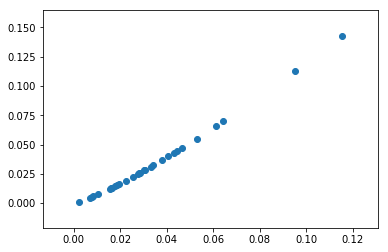

In [283]:
a = System2(n=30, sigma=10)
Ltrace, log, wtrace = a.solveL(0.01)
finalL = Ltrace.history[-1]
plt.scatter(finalL, a.A)

## See if this works

With a larger system, and different parameters

Iteration #250: 0.00016507833550081973
Iteration #500: 6.336321242667553e-08


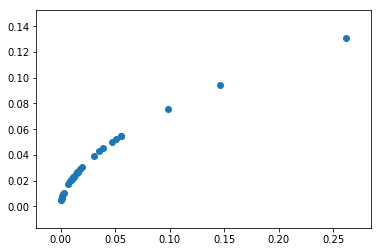

In [291]:
a = System2(n=30, eta=4)

Ltrace, logger, wtrace = a.solveL(learning_rate=0.01)

finalL = Ltrace.history[-1]
plt.scatter(finalL, a.A)

# What if we formulate this as a deep learning problem?

In [3]:
import torch
import torch.functional as F
import torch.optim as optim

In [1]:
class System3:
    def __init__(self, n=10, sigma=5, eta=1):
        self.n = n
        self.sigma = sigma
        self.eta = eta
        self.reset()
    
    def reset(self):
        n = self.n

        A = np.abs(np.random.randn(n))
        L = np.abs(np.random.randn(n))
        w = np.abs(np.random.randn(n))
        
        self.A = normalize(A)
        self.L = normalize(L)
        self.w = normalize(w)
        
        self.pi = self.getPi()
    
    # utility methods
    def getPi(self):
        """
        returns the spending (pi) given the wages in each region
        """
        w = self.w
        n = self.n
        
        pi = np.zeros((n,n))
        for j in range(n):
            pi_ij = (w/self.A) ** (1-self.sigma)
            pi_ij = normalize(pi_ij)
#             print(pi_ij, sum(pi_ij))
            pi[j, :] = pi_ij # set all the i's at once
            
        return pi
    
    def newWage(self):
        """
        returns the new wage for a given pi
        """
        return np.matmul(self.pi.T, self.w*self.L) / self.L
    
    def solveWage(self, trace=False):
        """
        For a given L, iteratively compute pi and w
        """
        wtrace, ltrace = None, None
        
        if trace:
            wtrace = Tracer()
            ltrace = Tracer()
        
        oldWage = self.w
        newWage = np.matmul(self.pi.T, self.w*self.L) / self.L
        loss = difference(newWage, oldWage)
        if trace:
            ltrace.log(loss)
        
        threshold = 1e-5/self.n
        max_iter = 4000
        
        i = 0
        while loss > threshold and i < max_iter:
            i+=1
            if trace:
                wtrace.log(self.w)
            
            # update w
            learning_rate = 0.1
            delta = newWage - oldWage
            self.w = oldWage + learning_rate * delta
            self.w = normalize(self.w)
            self.pi = self.getPi()
            
            # new iteration
            oldWage = self.w
            newWage = np.matmul(self.pi.T, self.w*self.L) / self.L
            loss = difference(newWage, oldWage)
            if trace:
                ltrace.log(loss)
        
        return wtrace, ltrace
    

# Some observations

* $\eta$ seems to control the degree to which the wage influences the location. If $\eta$ is very large, then the wage matters a lot, and people would move to the place **or at least it used to. now $\eta$ simply affects the learning rate, since everything smooths out eventually**
* we can also play with different initializations of $A$ to see if that changes anything

## Let's explore the spatialPreference() function:

```
        x = sum(w/self.A ** (1-sigma)) ** (1/(1-sigma))            
        numerator = (w/x)**eta # numerator
        lprime = normalize(numerator) # adds the denominator
            
        return lprime
    
```

In [221]:
economy.reset()
w = economy.w
w

array([0.0563968 , 0.03779029, 0.02880735, 0.01728311, 0.05067745,
       0.00998651, 0.01279852, 0.0192588 , 0.009584  , 0.0347511 ,
       0.03165686, 0.02414652, 0.09249942, 0.00122891, 0.02392189,
       0.02366708, 0.05544037, 0.01036221, 0.04598511, 0.0607546 ,
       0.06586429, 0.03042325, 0.00329343, 0.02891651, 0.095264  ,
       0.03925903, 0.00192433, 0.0108025 , 0.02352885, 0.0537269 ])

In [222]:
economy.sigma

5

Text(0,0.5,'Resulting L')

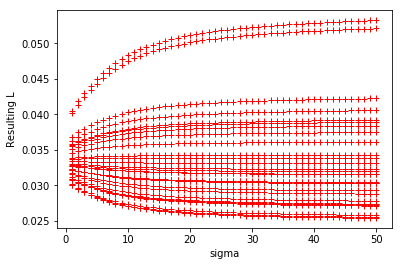

In [223]:
s = np.linspace(1.001, 50)
lists = []
eta = 5
for sigma in s:
    x = np.sum(w/economy.A ** (1-sigma)) ** (1/(1-sigma))
    numerator = np.exp(w/x)**eta
    numerator = normalize(numerator)
    lists.append(numerator)

_ = plt.plot(s, np.array(lists), 'r+', linewidth=1)
plt.xlabel('sigma')
plt.ylabel('Resulting L')